<a href="https://colab.research.google.com/github/Bicchie/News-Classification/blob/main/HLT_Articles_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
! pip install -q kaggle

#from google.colab import files
#_ = files.upload()

! mkdir -p ~/.kaggle
! cp "/content/gdrive/Shareddrives/HLT-ArticlesTagging/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d fabiochiusano/medium-articles --unzip

 98% 361M/369M [00:13<00:00, 28.6MB/s]
100% 369M/369M [00:14<00:00, 27.6MB/s]


In [ ]:
!pip install tensorflow==2.4.1 > null
!pip install tensorflow-text==2.4.1 > null
!pip install contractions > null
!pip install keras==2.3.1 > null
!pip install yake > null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import ast
import contractions
from collections import Counter
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
import sys
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
import time
from tqdm import tqdm
import yake


Using TensorFlow backend.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Data Collection and Preprocessing

In [ ]:
kaggle_df = pd.read_csv("/content/medium_articles.csv")
kaggle_df

,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology..."
...,...,...,...,...,...,...
192363,Why do you need a cleaning service?,What could be more important than having a tid...,https://medium.com/@ozneedcleaningau/why-do-yo...,[],2021-11-16 08:17:08.950000+00:00,"['Cleaning', 'Cleaning Services', 'Cleaning Co..."
192364,Daily cleaning and maintenance of bedding,Daily cleaning and maintenance of bedding\n\nW...,https://medium.com/@a198blwt/daily-cleaning-an...,[],2021-11-16 05:27:05.359000+00:00,"['Bedding', 'Cleaning', 'Maintain']"
192365,Beneficial Advice on Bond Cleaning!,The most important chore at the end is bond cl...,https://medium.com/@princegohil/beneficial-adv...,['Prince Shrawan'],2021-11-26 08:20:27.660000+00:00,"['Cleaning', 'End Of Lease Cleaning', 'Cleaners']"
192366,How I Learned Romanian in 37 Easy Steps,How I Learned Romanian in 37 Easy Steps\n\nHey...,https://medium.com/@lifeinromania/how-i-learne...,['Sam Ursu'],2017-11-27 08:09:19.025000+00:00,"['Romania', 'Language Learning', 'Storyofmylife']"


In [ ]:
xss = kaggle_df.tags.tolist()
flat_list = [x for xs in xss for x in ast.literal_eval(xs)]
counter = Counter(flat_list)
list({k: v for k, v in sorted(counter.items(), key=lambda item: -item[1])})[0:30]

['Blockchain',
 'Data Science',
 'Technology',
 'Programming',
 'Poetry',
 'Cryptocurrency',
 'Machine Learning',
 'Life',
 'Bitcoin',
 'Writing',
 'Politics',
 'Startup',
 'Life Lessons',
 'Self Improvement',
 'Covid 19',
 'Software Development',
 'Love',
 'Python',
 'Business',
 'Health',
 'Mental Health',
 'JavaScript',
 'Relationships',
 'Education',
 'Artificial Intelligence',
 'Culture',
 'Design',
 'Self',
 'Marketing',
 'Entrepreneurship']

These are the tags that we have by giving value to the number of articles that contain them and to have semantically different topics.

In [ ]:
Tags = {
    'Technology',
    'Politics',
    'Health',
    'Education',
    'Music',
    'Travel',
    'Finance',
    'History'
}

In [ ]:
column_tag = []
count = 0

# select the articles with the tag choosen
tags = kaggle_df.tags.tolist()
for tag_list in tags:
  for tag in ast.literal_eval(tag_list):
    if tag in Tags:
      temp = tag
      count = count + 1
  if count == 1:
    column_tag.append(temp)
  else:
    column_tag.append('NoTag')
  count = 0


kaggle_df['Tag'] = column_tag
kaggle_df

,title,text,url,authors,timestamp,tags,Tag
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci...",Health
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P...",NoTag
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We...",NoTag
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P...",Health
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology...",Health
...,...,...,...,...,...,...,...
192363,Why do you need a cleaning service?,What could be more important than having a tid...,https://medium.com/@ozneedcleaningau/why-do-yo...,[],2021-11-16 08:17:08.950000+00:00,"['Cleaning', 'Cleaning Services', 'Cleaning Co...",NoTag
192364,Daily cleaning and maintenance of bedding,Daily cleaning and maintenance of bedding\n\nW...,https://medium.com/@a198blwt/daily-cleaning-an...,[],2021-11-16 05:27:05.359000+00:00,"['Bedding', 'Cleaning', 'Maintain']",NoTag
192365,Beneficial Advice on Bond Cleaning!,The most important chore at the end is bond cl...,https://medium.com/@princegohil/beneficial-adv...,['Prince Shrawan'],2021-11-26 08:20:27.660000+00:00,"['Cleaning', 'End Of Lease Cleaning', 'Cleaners']",NoTag
192366,How I Learned Romanian in 37 Easy Steps,How I Learned Romanian in 37 Easy Steps\n\nHey...,https://medium.com/@lifeinromania/how-i-learne...,['Sam Ursu'],2017-11-27 08:09:19.025000+00:00,"['Romania', 'Language Learning', 'Storyofmylife']",NoTag


In [ ]:
filtered_df = kaggle_df[kaggle_df["Tag"] != 'NoTag']
filtered_df = filtered_df.drop("url", axis = 1)
filtered_df = filtered_df.drop("authors", axis = 1)
filtered_df = filtered_df.drop("timestamp", axis = 1)
filtered_df = filtered_df.drop("tags", axis = 1)
filtered_df = filtered_df.reset_index()
filtered_df = filtered_df.drop("title", axis = 1)
filtered_df = filtered_df.drop("index", axis = 1)

filtered_df = filtered_df.dropna()
filtered_df

,text,Tag
0,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,Health
1,Passionate about the synergy between science a...,Health
2,"You’ve heard of him, haven’t you? Phineas Gage...",Health
3,"Mentally, Young Adults Are Suffering Most From...",Health
4,Dr Faisal Dar — Pioneer of Liver Transplantati...,Health
...,...,...
24015,"The Andaman Islands, a conglomerate of pristin...",Travel
24016,Whether people are traveling for pleasure or b...,Travel
24017,Photo credit: Jenna Foxton\n\nShambala is a fo...,Music
24018,"Type 2 diabetes is on the rise globally, and h...",Health


In [ ]:
def category_histogram(df,text):
  article_tags = df.Tag
  unique_tag = Counter(article_tags)
  dictionary = dict(unique_tag)
  tag = {
    'Technology':0,
    'Politics':0,
    'Health':0,
    'Education':0,
    'Music':0,
    'Travel':0,
    'Finance':0,
    'History':0
  } 

  for key, value in dictionary.items():
    tag[key] = value

  plt.figure(figsize=(12,5))
  plt.bar(range(len(tag)), list(tag.values()), align='center', color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange', 'tab:cyan', 'tab:pink', 'tab:brown'])
  plt.xticks(range(len(tag)), list(tag.keys()))
  plt.title(text)
  plt.show()

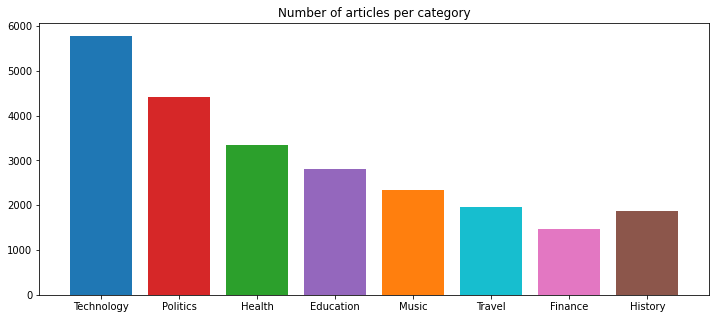

In [ ]:
category_histogram(filtered_df,"Number of articles per category")

In [ ]:

Tags_Text = {
    'Technology':0,
    'Politics':0,
    'Health':0,
    'Education':0,
    'Music':0,
    'Travel':0,
    'Finance':0,
    'History':0
}

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
for tag in Tags:
  df_filtered_per_tag = filtered_df[filtered_df['Tag'] == tag]
  list_text = df_filtered_per_tag.text
  for text in list_text:
    Tags_Text[tag] = Tags_Text[tag] + len(tokenizer.tokenize(text))
  
  Tags_Text[tag] = Tags_Text[tag]/len(df_filtered_per_tag)

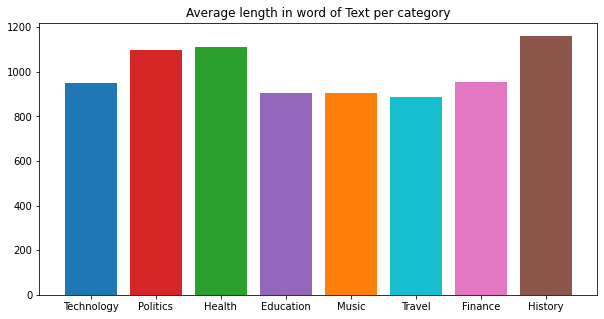

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(len(Tags_Text)), list(Tags_Text.values()), align='center', color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange', 'tab:cyan', 'tab:pink', 'tab:brown'])
plt.xticks(range(len(Tags_Text)), list(Tags_Text.keys()))
plt.title("Average length in word of Text per category")
plt.show()

In [ ]:
! pip install lexical-diversity
from lexical_diversity import lex_div as ld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 15.3 MB/s 


In [ ]:
test = {
    'Technology':0,
    'Politics':0,
    'Health':0,
    'Education':0,
    'Music':0,
    'Travel':0,
    'Finance':0,
    'History':0
}

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
for tag in Tags:
  df_filtered_per_tag = filtered_df[filtered_df['Tag'] == tag]
  list_text = df_filtered_per_tag.text
  sum = 0
  for text in tqdm(list_text):
    flt = ld.flemmatize(text)
    sum = sum + ld.ttr(flt)
  
  test[tag] = sum/len(df_filtered_per_tag)

100%|██████████| 2346/2346 [00:01<00:00, 1518.86it/s]


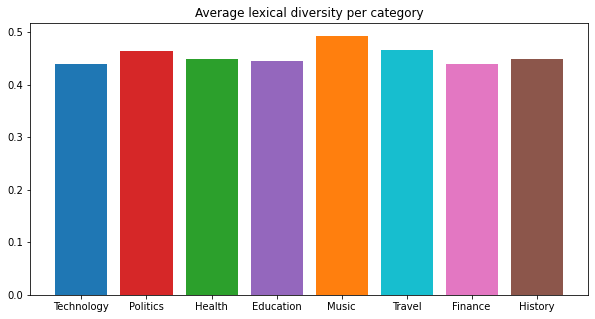

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(len(test)), list(test.values()), align='center', color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange', 'tab:cyan', 'tab:pink', 'tab:brown'])
plt.xticks(range(len(test)), list(test.keys()))
plt.title("Average lexical diversity per category")
plt.show()

In [ ]:
articles = filtered_df.text
articles

0        Photo by Josh Riemer on Unsplash\n\nMerry Chri...
1        Passionate about the synergy between science a...
2        You’ve heard of him, haven’t you? Phineas Gage...
3        Mentally, Young Adults Are Suffering Most From...
4        Dr Faisal Dar — Pioneer of Liver Transplantati...
                               ...                        
24015    The Andaman Islands, a conglomerate of pristin...
24016    Whether people are traveling for pleasure or b...
24017    Photo credit: Jenna Foxton\n\nShambala is a fo...
24018    Type 2 diabetes is on the rise globally, and h...
24019    The Concept of Stem Cells\n\nEmbryonic stem ce...
Name: text, Length: 24020, dtype: object

In [ ]:
expanded_articles = []

for article in tqdm(articles):
  # creating an empty list
  expanded_words = []   
  for word in article.split():
    # using contractions.fix to expand the shortened words
    expanded_words.append(contractions.fix(word.lower()))  
  new_article = ' '.join(expanded_words)
  new_article = re.sub(r'[^\w\s]', '', new_article)
  expanded_articles.append(new_article)

100%|██████████| 24020/24020 [01:08<00:00, 352.05it/s]


In [ ]:
filtered_df['TextPreprocessed'] = expanded_articles
filtered_df = filtered_df.drop("text", axis = 1)
filtered_df

,Tag,TextPreprocessed
0,Health,photo by josh riemer on unsplash merry christm...
1,Health,passionate about the synergy between science a...
2,Health,you have heard of him have not you phineas gag...
3,Health,mentally young adults are suffering most from ...
4,Health,dr faisal dar pioneer of liver transplantatio...
...,...,...
24015,Travel,the andaman islands a conglomerate of pristine...
24016,Travel,whether people are traveling for pleasure or b...
24017,Music,photo credit jenna foxton shambala is a fourda...
24018,Health,type 2 diabetes is on the rise globally and he...


In [ ]:
filtered_df.to_csv("/content/gdrive/Shareddrives/HLT-ArticlesTagging/dataframeForKeywords.csv", index = False)

In [ ]:
Num_Tags = {
    'Technology':0,
    'Politics':1,
    'Health':2,
    'Education':3,
    'Music':4,
    'Travel':5,
    'Finance':6,
    'History':7
}

Downsampling

In [ ]:
filtered_df['Num_Tag']=filtered_df['Tag'].apply(lambda x: Num_Tags[x] )

class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7 = filtered_df.Num_Tag.value_counts()
c0 = filtered_df[filtered_df['Num_Tag'] == 0]
c1 = filtered_df[filtered_df['Num_Tag'] == 1]
c2 = filtered_df[filtered_df['Num_Tag'] == 2]
c3 = filtered_df[filtered_df['Num_Tag'] == 3]
c4 = filtered_df[filtered_df['Num_Tag'] == 4]
c5 = filtered_df[filtered_df['Num_Tag'] == 5]
c6 = filtered_df[filtered_df['Num_Tag'] == 6]
c7 = filtered_df[filtered_df['Num_Tag'] == 7]
df_0 = c0.sample(class_7)
df_1 = c1.sample(class_7)
df_2 = c2.sample(class_7)
df_3 = c3.sample(class_7)
df_4 = c4.sample(class_7)
df_5 = c5.sample(class_7)
df_7 = c7.sample(class_7)
filtered_df = pd.concat([df_0,df_1,df_2,df_3,df_4,df_5,c6,df_7],axis=0)
filtered_df

,Tag,TextPreprocessed,Num_Tag
14676,Technology,when life closes a door you open many zoom win...,0
2924,Technology,for some 5g is a miracle network that will bri...,0
4962,Technology,the firstever published website came to the in...,0
15838,Technology,my reluctant iphone 12 purchase story time whe...,0
5253,Technology,baseline image on the left and incorrect backg...,0
...,...,...,...
797,History,steve jobs dark past the time steve jobs cheat...,7
11409,History,the san francisco oakland bay bridge had been ...,7
21947,History,the skydiver saved by fire ants after plunging...,7
15668,History,a collection of open letters to my family and ...,7


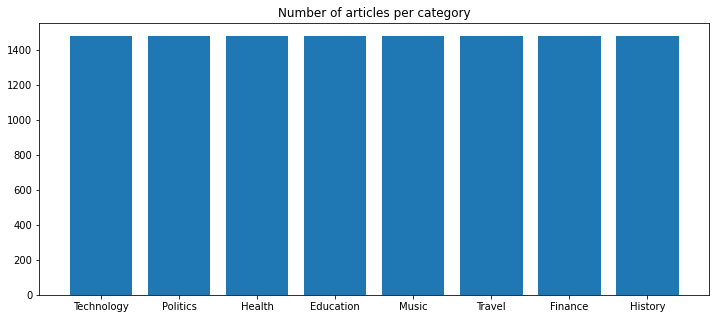

In [ ]:
category_histogram(filtered_df,"Number of articles per category")

In [ ]:
filtered_df.to_csv("/content/gdrive/Shareddrives/HLT-ArticlesTagging/DataframeSampled.csv", index = False)

# Transformer Classification

In [ ]:
filtered_df = pd.read_csv("/content/gdrive/Shareddrives/HLT-ArticlesTagging/DataframeSampled.csv").dropna()

In [ ]:
NUM_CLASSES=8

MODEL_DIR="/content/gdrive/Shareddrives/HLT-ArticlesTagging/model/"

BATCH_SIZE=32
EPOCHS=20

LABELS=['Technology','Politics','Health','Education','Music','Travel', 'Finance','History']

In [ ]:
filtered_df_real = filtered_df.copy()

In [ ]:
# y contains the Category of the article
y = filtered_df_real.pop('Num_Tag').to_frame()
# x contains the Title and Text of the article
x = filtered_df_real

*   Train: 70%
*   Validation: 15% 
*   Test: 15%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        x, y,stratify=y, test_size=0.3, random_state=3827)

X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, stratify=y_test, test_size=0.5, random_state=3827)

In [ ]:
def get_predictions(X_test, y_test, model, include_softMax=False):
  '''Given a model and a dataset returns the gold and predicted labels'''
  gold_labels = y_test['Num_Tag'].to_numpy()
  
  start_time = time.time()

  prediction = model.predict(X_test)

  inference_time = time.time() - start_time

  if include_softMax:
    prediction = tf.nn.softmax(prediction).numpy()

  pred_labels = prediction.argmax(axis=1)
  pred_labels = np.array([LABELS[i] for i in pred_labels])
  gold_labels = np.array([LABELS[i] for i in gold_labels])

  return pred_labels, gold_labels, inference_time

In [ ]:
def get_model(MODEL, PREPROCESS, save, model_name):
  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = PREPROCESS(text_input)
  outputs = MODEL(preprocessed_text)
  # Neural network layers
  l = tf.keras.layers.Dropout(0.3, name="dropout")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name="output")(l)
  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [l])
  callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
  optimizer = tf.keras.optimizers.RMSprop()
  #optimizer = tf.keras.optimizers.SGD()
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  model.fit(X_train.TextPreprocessed, y_train.Num_Tag, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_data=(X_val.TextPreprocessed, y_val.Num_Tag),verbose=1, callbacks = callback)
  if save:
    model.save(MODEL_DIR + model_name, include_optimizer=False)
  return model

## Small Bert Model

In [ ]:
BERT_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")
BERT_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(BERT_MODEL, BERT_PREPROCESS_MODEL, True, "smallBert.h5")

Epoch 1/20
259/259 [==============================] - 50s 190ms/step - loss: 1.9117 - accuracy: 0.2966 - val_loss: 1.2277 - val_accuracy: 0.5981
Epoch 2/20
259/259 [==============================] - 50s 192ms/step - loss: 1.2966 - accuracy: 0.5572 - val_loss: 1.1007 - val_accuracy: 0.6421
Epoch 3/20
259/259 [==============================] - 51s 197ms/step - loss: 1.2020 - accuracy: 0.5913 - val_loss: 1.0791 - val_accuracy: 0.6415
Epoch 4/20
259/259 [==============================] - 49s 190ms/step - loss: 1.1537 - accuracy: 0.6107 - val_loss: 1.0382 - val_accuracy: 0.6561
Epoch 5/20
259/259 [==============================] - 50s 193ms/step - loss: 1.1260 - accuracy: 0.6242 - val_loss: 1.0125 - val_accuracy: 0.6674
Epoch 6/20
259/259 [==============================] - 53s 204ms/step - loss: 1.0618 - accuracy: 0.6412 - val_loss: 1.0078 - val_accuracy: 0.6764
Epoch 7/20
259/259 [==============================] - 50s 195ms/step - loss: 1.0801 - accuracy: 0.6434 - val_loss: 1.0210 - val_ac

In [ ]:
model.evaluate(X_test.TextPreprocessed,y_test)

56/56 [==============================] - 9s 151ms/step - loss: 0.9387 - accuracy: 0.6883


[0.9386809468269348, 0.6882750988006592]

7.354382038116455


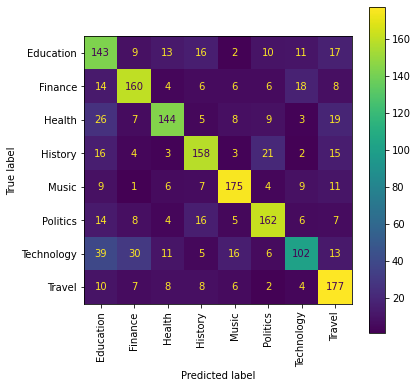

In [ ]:
pred_lab, gold_lab, inference_time = get_predictions(X_test.TextPreprocessed,y_test,model,True)

print(inference_time)

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(gold_lab, pred_lab, xticks_rotation='vertical', ax=ax)

In [ ]:
f1_summary = f1_score(gold_lab, pred_lab, average=None)
f1_micro = f1_score(gold_lab, pred_lab, average="micro")
f1_macro = f1_score(gold_lab, pred_lab, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

[0.58130081 0.71428571 0.69565217 0.71331828 0.79006772 0.73303167
 0.54111406 0.72392638]
0.6882750845546787
0.6865871023316551


## Albert Model

In [ ]:
ALBERT_MODEL=hub.KerasLayer('https://tfhub.dev/tensorflow/albert_en_base/2')
ALBERT_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")

In [ ]:
model = get_model(ALBERT_MODEL, ALBERT_PREPROCESS_MODEL, True, "Albert.h5")

Epoch 1/20
259/259 [==============================] - 129s 472ms/step - loss: 2.3576 - accuracy: 0.1455 - val_loss: 1.9607 - val_accuracy: 0.2582
Epoch 2/20
259/259 [==============================] - 122s 470ms/step - loss: 2.1264 - accuracy: 0.2129 - val_loss: 1.8664 - val_accuracy: 0.3213
Epoch 3/20
259/259 [==============================] - 122s 472ms/step - loss: 1.9932 - accuracy: 0.2621 - val_loss: 1.8510 - val_accuracy: 0.3224
Epoch 4/20
259/259 [==============================] - 125s 484ms/step - loss: 1.9212 - accuracy: 0.2954 - val_loss: 1.7095 - val_accuracy: 0.3884
Epoch 5/20
259/259 [==============================] - 125s 483ms/step - loss: 1.8818 - accuracy: 0.3034 - val_loss: 1.6589 - val_accuracy: 0.4098
Epoch 6/20
259/259 [==============================] - 125s 484ms/step - loss: 1.8490 - accuracy: 0.3250 - val_loss: 1.6947 - val_accuracy: 0.3839
Epoch 7/20
259/259 [==============================] - 124s 479ms/step - loss: 1.8144 - accuracy: 0.3391 - val_loss: 1.7143 -

In [ ]:
model.evaluate(X_test.TextPreprocessed,y_test)

56/56 [==============================] - 22s 391ms/step - loss: 1.6835 - accuracy: 0.3952


[1.683483600616455, 0.39515221118927]

18.580580472946167


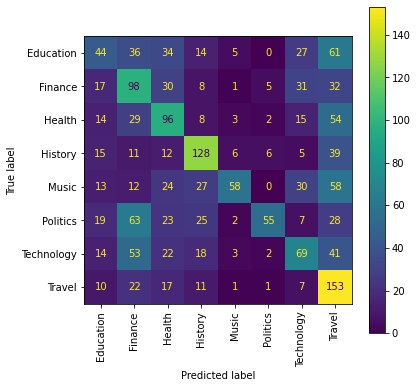

In [ ]:
pred_lab, gold_lab, inference_time = get_predictions(X_test.TextPreprocessed,y_test,model,True)

print(inference_time)

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(gold_lab, pred_lab, xticks_rotation='vertical', ax=ax)

In [ ]:
f1_summary = f1_score(gold_lab, pred_lab, average=None)
f1_micro = f1_score(gold_lab, pred_lab, average="micro")
f1_macro = f1_score(gold_lab, pred_lab, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

[0.23978202 0.35897436 0.40083507 0.55531453 0.38538206 0.37542662
 0.33414044 0.44476744]
0.395152198421646
0.3868278175839345


## Electra Model

In [ ]:
ELECTRA_MODEL=hub.KerasLayer('https://tfhub.dev/google/electra_small/2')
ELECTRA_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(ELECTRA_MODEL, ELECTRA_PREPROCESS_MODEL, True, "Electra.h5")

Epoch 1/20
259/259 [==============================] - 62s 212ms/step - loss: 2.1793 - accuracy: 0.1441 - val_loss: 1.9432 - val_accuracy: 0.2373
Epoch 2/20
259/259 [==============================] - 52s 200ms/step - loss: 1.9967 - accuracy: 0.2192 - val_loss: 1.8510 - val_accuracy: 0.3117
Epoch 3/20
259/259 [==============================] - 53s 206ms/step - loss: 1.9070 - accuracy: 0.2689 - val_loss: 1.7787 - val_accuracy: 0.3501
Epoch 4/20
259/259 [==============================] - 52s 200ms/step - loss: 1.8511 - accuracy: 0.3012 - val_loss: 1.7480 - val_accuracy: 0.3737
Epoch 5/20
259/259 [==============================] - 51s 199ms/step - loss: 1.8161 - accuracy: 0.3079 - val_loss: 1.7199 - val_accuracy: 0.3839
Epoch 6/20
259/259 [==============================] - 53s 205ms/step - loss: 1.8095 - accuracy: 0.3140 - val_loss: 1.6968 - val_accuracy: 0.3963
Epoch 7/20
259/259 [==============================] - 51s 198ms/step - loss: 1.7965 - accuracy: 0.3290 - val_loss: 1.6878 - val_ac

In [ ]:
model.evaluate(X_test.TextPreprocessed,y_test)

56/56 [==============================] - 10s 159ms/step - loss: 1.6649 - accuracy: 0.4177


[1.6649426221847534, 0.4177001118659973]

7.705808639526367


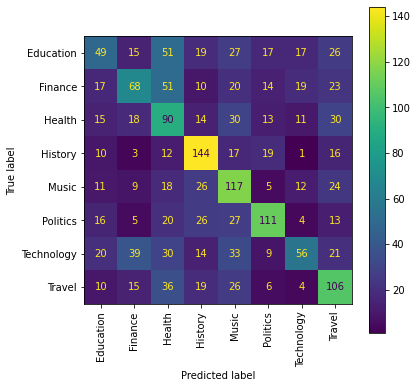

In [ ]:
pred_lab, gold_lab, inference_time = get_predictions(X_test.TextPreprocessed,y_test,model,True)

print(inference_time)

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(gold_lab, pred_lab, xticks_rotation='vertical', ax=ax)

In [ ]:
f1_summary = f1_score(gold_lab, pred_lab, average=None)
f1_micro = f1_score(gold_lab, pred_lab, average="micro")
f1_macro = f1_score(gold_lab, pred_lab, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

[0.26558266 0.34517766 0.34026465 0.58299595 0.45086705 0.53365385
 0.32369942 0.44074844]
0.4177001127395716
0.4103737104240577


## Bert Base Model

In [ ]:
BERT_BASE_MODEL=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
BERT_BASE_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(BERT_BASE_MODEL, BERT_BASE_PREPROCESS_MODEL, True, "BertBase.h5")

Epoch 1/20
259/259 [==============================] - 127s 456ms/step - loss: 2.1409 - accuracy: 0.1803 - val_loss: 1.7348 - val_accuracy: 0.4572
Epoch 2/20
259/259 [==============================] - 120s 465ms/step - loss: 1.8293 - accuracy: 0.3247 - val_loss: 1.5938 - val_accuracy: 0.4707
Epoch 3/20
259/259 [==============================] - 119s 461ms/step - loss: 1.6545 - accuracy: 0.4136 - val_loss: 1.5366 - val_accuracy: 0.4391
Epoch 4/20
259/259 [==============================] - 119s 460ms/step - loss: 1.5721 - accuracy: 0.4448 - val_loss: 1.4141 - val_accuracy: 0.5293
Epoch 5/20
259/259 [==============================] - 119s 459ms/step - loss: 1.5062 - accuracy: 0.4608 - val_loss: 1.3530 - val_accuracy: 0.5411
Epoch 6/20
259/259 [==============================] - 119s 460ms/step - loss: 1.4660 - accuracy: 0.4879 - val_loss: 1.2698 - val_accuracy: 0.6257
Epoch 7/20
259/259 [==============================] - 119s 458ms/step - loss: 1.4407 - accuracy: 0.5027 - val_loss: 1.2461 -

In [ ]:
model.evaluate(X_test.TextPreprocessed,y_test)

56/56 [==============================] - 22s 377ms/step - loss: 1.2194 - accuracy: 0.6246


[1.219404935836792, 0.6245772242546082]

17.948065519332886


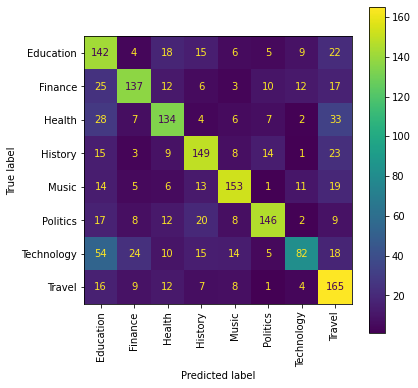

In [ ]:
pred_lab, gold_lab, inference_time = get_predictions(X_test.TextPreprocessed,y_test,model,True)

print(inference_time)

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(gold_lab, pred_lab, xticks_rotation='vertical', ax=ax)

In [ ]:
f1_summary = f1_score(gold_lab, pred_lab, average=None)
f1_micro = f1_score(gold_lab, pred_lab, average="micro")
f1_macro = f1_score(gold_lab, pred_lab, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

[0.53383459 0.65393795 0.61751152 0.66075388 0.71495327 0.71046229
 0.47536232 0.625     ]
0.6245772266065389
0.623976976492105


## Bert Expert Model

In [ ]:
BERT_EXPERT_MODEL=hub.KerasLayer('https://tfhub.dev/google/experts/bert/wiki_books/2')
BERT_EXPERT_PREPROCESS_MODEL=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
model = get_model(BERT_EXPERT_MODEL, BERT_EXPERT_PREPROCESS_MODEL, True, "BertExpert.h5")

Epoch 1/20
259/259 [==============================] - 127s 461ms/step - loss: 2.1546 - accuracy: 0.1741 - val_loss: 1.8250 - val_accuracy: 0.2943
Epoch 2/20
259/259 [==============================] - 119s 461ms/step - loss: 1.8594 - accuracy: 0.3093 - val_loss: 1.6845 - val_accuracy: 0.3997
Epoch 3/20
259/259 [==============================] - 119s 460ms/step - loss: 1.7038 - accuracy: 0.3782 - val_loss: 1.5572 - val_accuracy: 0.4820
Epoch 4/20
259/259 [==============================] - 118s 458ms/step - loss: 1.6293 - accuracy: 0.4127 - val_loss: 1.5263 - val_accuracy: 0.4961
Epoch 5/20
259/259 [==============================] - 118s 456ms/step - loss: 1.5788 - accuracy: 0.4354 - val_loss: 1.4503 - val_accuracy: 0.5214
Epoch 6/20
259/259 [==============================] - 118s 457ms/step - loss: 1.5502 - accuracy: 0.4480 - val_loss: 1.4154 - val_accuracy: 0.5485
Epoch 7/20
259/259 [==============================] - 118s 456ms/step - loss: 1.4986 - accuracy: 0.4614 - val_loss: 1.3895 -

In [ ]:
model.evaluate(X_test.TextPreprocessed,y_test)

56/56 [==============================] - 22s 378ms/step - loss: 1.2732 - accuracy: 0.5795


[1.2732239961624146, 0.5794814229011536]

17.811403036117554


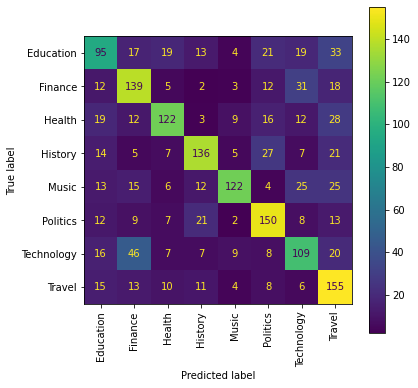

In [ ]:
pred_lab, gold_lab, inference_time = get_predictions(X_test.TextPreprocessed,y_test,model,True)

print(inference_time)

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(gold_lab, pred_lab, xticks_rotation='vertical', ax=ax)

In [ ]:
f1_summary = f1_score(gold_lab, pred_lab, average=None)
f1_micro = f1_score(gold_lab, pred_lab, average="micro")
f1_macro = f1_score(gold_lab, pred_lab, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

[0.45563549 0.58158996 0.6039604  0.63700234 0.64210526 0.64102564
 0.49658314 0.57943925]
0.5794813979706878
0.5796676859692058


# Keyword extraction and classification with Embeddings

In [ ]:
filtered_df = pd.read_csv("/content/gdrive/Shareddrives/HLT-ArticlesTagging/DataframeSampled.csv")

In [ ]:
X_train, filtered_df = train_test_split(filtered_df, test_size=0.15, random_state=3827)

In [ ]:
kw_extractor = yake.KeywordExtractor()
language = "en"
max_ngram_size = 1
deduplication_threshold = 0.9
numOfKeywords = 9
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)

keywords_column = []
articles = filtered_df.TextPreprocessed

for article in tqdm(articles):
  keywords = custom_kw_extractor.extract_keywords(article)
  keywords_list = []
  for kw in keywords:
    keywords_list.append(kw[0])
  keywords_column.append(keywords_list)

filtered_df['Keywords'] = keywords_column


100%|██████████| 1774/1774 [01:49<00:00, 16.15it/s]


In [ ]:
filtered_df

,Tag,TextPreprocessed,Num_Tag,Keywords
6192,Music,intro am f c them x2 verse am f c them because...,4,"[sky, full, stars, care, verse, give, tear, in..."
4121,Health,by barbara k rimer drph chair presidents cance...,2,"[health, cancer, information, care, president,..."
8427,Travel,hotel reservation system hotel apis native mo...,5,"[reservation, hotel, system, business, apps, o..."
10165,Finance,10 practical steps to becoming debt free in 3 ...,6,"[credit, card, cards, rate, debt, pay, loans, ..."
7185,Music,outdoor security cameras can be your first lin...,4,"[outdoor, nonproduct, blink, twocamera, link, ..."
...,...,...,...,...
10416,History,the deadliest female sniper in recorded histor...,7,"[lyudmila, war, soviet, sniper, pavlichenko, s..."
4789,Education,the operationarchitecture model is a coevoluti...,3,"[ship, design, field, architecture, activities..."
929,Technology,samsung galaxy z fold 3 and z flip 3 can now a...,0,"[galaxy, beta, fold, flip, samsung, latest, us..."
4695,Education,image sourcestatecraft published by coin idol...,3,"[digital, cryptocurrency, blockchain, project,..."


In [ ]:
filtered_df.to_csv("/content/gdrive/Shareddrives/HLT-ArticlesTagging/dataframeWithKeywords.csv", index = False)

In [ ]:
filtered_df = pd.read_csv("/content/gdrive/Shareddrives/HLT-ArticlesTagging/dataframeWithKeywords.csv")

##GLOVE

In [ ]:
! kaggle datasets download -d danielwillgeorge/glove6b100dtxt --unzip

 95% 125M/131M [00:01<00:00, 62.3MB/s]
100% 131M/131M [00:01<00:00, 82.7MB/s]


In [ ]:
glove_filename='glove.6B.100d.txt'

# Variable for data directory
glove_path = "/content/glove.6B.100d.txt"

word2vec_output_file = glove_filename+'.word2vec'
# saves the Glove embeddings in the word2vec format that will be loaded later
glove2word2vec(glove_path, word2vec_output_file)

(400000, 100)

In [ ]:
# load the Stanford GloVe model
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
embeddings_column = []
keyword_lists = filtered_df.Keywords

for keyword_list in tqdm(keyword_lists):
  embedding_list = []
  for keyword in keyword_list:
    try:
      embedding_list.append(model.get_vector(keyword))
    except KeyError:
      continue
  embeddings_column.append(embedding_list)

filtered_df['KeywordEmbeddings'] = embeddings_column

100%|██████████| 1774/1774 [00:00<00:00, 58321.80it/s]


In [ ]:
embeddings_dictionary = {
    'Technology':0,
    'Politics':0,
    'Health':0,
    'Education':0,
    'Music':0,
    'Travel':0,
    'Finance':0,
    'History':0
}

Computing the embeddings for each label.

In [ ]:
LABELS=['Technology','Politics','Health','Education','Music','Travel','Finance','History']
for label in LABELS:
  embeddings_dictionary[label] = model.get_vector(label.lower())

In [ ]:
def predict_tags (filtered_df):
  keyword_embeddings = filtered_df.KeywordEmbeddings
  predicted_tags = []

  for embedding_list in tqdm(keyword_embeddings):
    tag_list = []
    for embedding in embedding_list:
      max = 0
      tag = ''
      for elem in embeddings_dictionary:
        result=cosine_similarity(embedding.reshape(1,-1),embeddings_dictionary[elem].reshape(1,-1))
        if result > max:
          max = result
          tag = elem
      tag_list.append(tag)
    if len(tag_list) > 0:
      occurence_count = Counter(tag_list)
      most_common_item = occurence_count.most_common(1)[0][0]
      predicted_tags.append(most_common_item)
    else:
      predicted_tags.append("unknown")
  filtered_df['PredictedTag'] = predicted_tags
  return filtered_df

In [ ]:
filtered_df = predict_tags(filtered_df)

100%|██████████| 1774/1774 [00:27<00:00, 64.30it/s]


In [ ]:
filtered_df.to_csv('/content/gdrive/Shareddrives/HLT-ArticlesTagging/dataframeWithKeywordsLabeled.csv', index=False)

In [ ]:
cleared_df = filtered_df[filtered_df["PredictedTag"] != '']
cleared_df = cleared_df[cleared_df["PredictedTag"] != 'unknown']

In [ ]:
gold_lab = cleared_df.Tag.tolist()
pred_lab = cleared_df.PredictedTag.tolist()

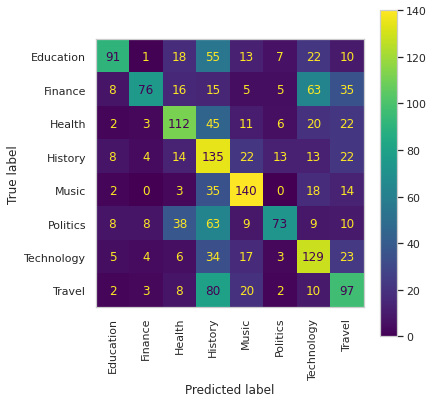

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
ConfusionMatrixDisplay.from_predictions(gold_lab, pred_lab, xticks_rotation='vertical', ax=ax)

In [ ]:
test = cleared_df[cleared_df['Tag'] == cleared_df['PredictedTag']]
accuracy = len(test)/len(cleared_df)
accuracy

0.48328611898017

In [ ]:
f1_summary = f1_score(gold_lab, pred_lab, average=None)
f1_micro = f1_score(gold_lab, pred_lab, average="micro")
f1_macro = f1_score(gold_lab, pred_lab, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

[0.53061224 0.47204969 0.51376147 0.38961039 0.62360802 0.44648318
 0.51089109 0.42637363]
0.48328611898017
0.48917371319591185


# Classification with Bayes

In [ ]:
filtered_df = pd.read_csv("/content/gdrive/Shareddrives/HLT-ArticlesTagging/DataframeSampled.csv")
filtered_df

,Tag,TextPreprocessed,Num_Tag
0,Technology,when life closes a door you open many zoom win...,0
1,Technology,for some 5g is a miracle network that will bri...,0
2,Technology,the firstever published website came to the in...,0
3,Technology,my reluctant iphone 12 purchase story time whe...,0
4,Technology,baseline image on the left and incorrect backg...,0
...,...,...,...
11819,History,steve jobs dark past the time steve jobs cheat...,7
11820,History,the san francisco oakland bay bridge had been ...,7
11821,History,the skydiver saved by fire ants after plunging...,7
11822,History,a collection of open letters to my family and ...,7


In [ ]:
# y contains the Category of the article
y = filtered_df.pop('Tag').to_frame()
# x contains the Title and Text of the article
x = filtered_df

X_train, X_test, y_train, y_test = train_test_split(
        x, y,stratify=y, test_size=0.3, random_state=3827)

X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, stratify=y_test, test_size=0.5, random_state=3827)

In [ ]:
# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Train the model using the training data
start_time = time.time()
model.fit(X_train.TextPreprocessed, y_train.Tag)
training_time = time.time() - start_time

print("Training Time: " + str(training_time))

Training Time: 6.823042392730713


In [ ]:
start_time = time.time()
predicted_categories = model.predict(X_test.TextPreprocessed)
inference_time = time.time() - start_time
print("Inference Time: " + str(inference_time))

Inference Time: 2.429478645324707


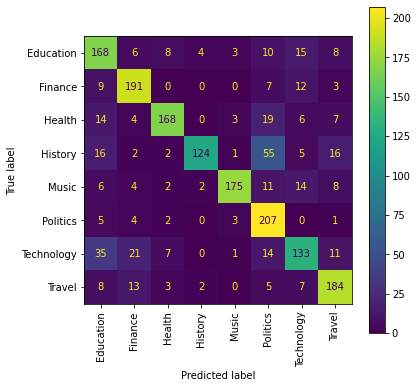

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test.Tag.tolist(), predicted_categories.tolist(), xticks_rotation='vertical', ax=ax)

In [ ]:
print("The accuracy is {}".format(accuracy_score(y_test.Tag, predicted_categories)))

The accuracy is 0.7609921082299888


In [ ]:
f1_summary = f1_score(y_test.Tag.tolist(), predicted_categories.tolist(), average=None)
f1_micro = f1_score(y_test.Tag.tolist(), predicted_categories.tolist(), average="micro")
f1_macro = f1_score(y_test.Tag.tolist(), predicted_categories.tolist(), average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

[0.69565217 0.81798715 0.81355932 0.70254958 0.85784314 0.75272727
 0.64251208 0.8       ]
0.7609921082299888
0.7603538387911106


# CNN 

In [ ]:
#the path for Glove embeddings
GLOVE_PATH = "/content/glove.6B.100d.txt"
# make the max word length to be constant
MAX_WORDS = 2000
MAX_SEQUENCE_LENGTH = 1000
# the dimension of vectors to be used
EMBEDDING_DIM = 100
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.5
batch_size = 30
epochs = 20

In [ ]:
! kaggle datasets download -d danielwillgeorge/glove6b100dtxt --unzip

 96% 126M/131M [00:01<00:00, 85.2MB/s]
100% 131M/131M [00:01<00:00, 84.2MB/s]


In [ ]:
filtered_df = pd.read_csv("/content/gdrive/Shareddrives/HLT-ArticlesTagging/DataframeSampled.csv").dropna()
filtered_df

,Tag,TextPreprocessed,Num_Tag
0,Technology,when life closes a door you open many zoom win...,0
1,Technology,for some 5g is a miracle network that will bri...,0
2,Technology,the firstever published website came to the in...,0
3,Technology,my reluctant iphone 12 purchase story time whe...,0
4,Technology,baseline image on the left and incorrect backg...,0
...,...,...,...
11819,History,steve jobs dark past the time steve jobs cheat...,7
11820,History,the san francisco oakland bay bridge had been ...,7
11821,History,the skydiver saved by fire ants after plunging...,7
11822,History,a collection of open letters to my family and ...,7


In [ ]:
# y contains the Category of the article
y = filtered_df.pop('Num_Tag').to_frame()
# x contains the Title and Text of the article
x = filtered_df

In [ ]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)
# updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency
tokenizer.fit_on_texts(filtered_df.TextPreprocessed)
#Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
sequences =  tokenizer.texts_to_sequences(filtered_df.TextPreprocessed)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(y.Num_Tag))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels)

unique words : 196460
Shape of data tensor: (11824, 1000)
Shape of label tensor: (11824, 8)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
list(word_index)[:20]

['the',
 'to',
 'and',
 'of',
 'a',
 'in',
 'is',
 'that',
 'it',
 'for',
 'i',
 'you',
 'not',
 'are',
 'with',
 'on',
 'as',
 'this',
 'was',
 'we']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        data, labels,stratify=y, test_size=0.3, random_state=3827)

X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, stratify=y_test, test_size=0.5, random_state=3827)

In [ ]:
embeddings_index = {}
f = open(GLOVE_PATH)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=8, activation='softmax')(dropout)

# this creates a model that includes
model = tf.keras.Model(inputs=inputs, outputs=output)


callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

adam = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

(None, 1000, 100)
(None, 1000, 100, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 100)    19646100    input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1000, 100, 1) 0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 998, 1, 512)  154112      reshape[0][0]                    
_______________________________________________________

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callback, validation_data=(X_val, y_val))

Epoch 1/20
276/276 [==============================] - 32s 74ms/step - loss: 3.0139 - accuracy: 0.1594 - val_loss: 1.3972 - val_accuracy: 0.6291
Epoch 2/20
276/276 [==============================] - 20s 73ms/step - loss: 1.9255 - accuracy: 0.3469 - val_loss: 1.0649 - val_accuracy: 0.7001
Epoch 3/20
276/276 [==============================] - 21s 78ms/step - loss: 1.4012 - accuracy: 0.5116 - val_loss: 0.9295 - val_accuracy: 0.7097
Epoch 4/20
276/276 [==============================] - 21s 77ms/step - loss: 1.1195 - accuracy: 0.6203 - val_loss: 0.8684 - val_accuracy: 0.7300
Epoch 5/20
276/276 [==============================] - 21s 76ms/step - loss: 0.9656 - accuracy: 0.6676 - val_loss: 0.8227 - val_accuracy: 0.7475
Epoch 6/20
276/276 [==============================] - 21s 76ms/step - loss: 0.8439 - accuracy: 0.7248 - val_loss: 0.7963 - val_accuracy: 0.7514
Epoch 7/20
276/276 [==============================] - 21s 77ms/step - loss: 0.7827 - accuracy: 0.7421 - val_loss: 0.7680 - val_accuracy:

In [ ]:
model.save("/content/gdrive/Shareddrives/HLT-ArticlesTagging/model/CNNWordEmbGlove.h5", include_optimizer=False)

In [ ]:
model.evaluate(X_test,y_test)

56/56 [==============================] - 2s 32ms/step - loss: 0.6439 - accuracy: 0.7982


[0.6439020037651062, 0.7981961965560913]

In [ ]:
start_time = time.time()
pred_labels = model.predict(X_test)
inference_time = time.time() - start_time
print(inference_time)

1.5485806465148926


In [ ]:
LABELS=['Technology','Politics','Health','Education','Music','Travel','Finance','History']
labels_list = []
for pred_label in pred_labels:
  label = LABELS[np.argmax(pred_label)]
  labels_list.append(label)

gold_lab = []
for true_lab in y_test:
  label = LABELS[np.argmax(true_lab)]
  gold_lab.append(label)

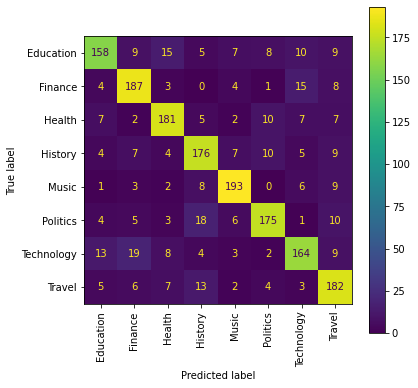

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(gold_lab, labels_list, xticks_rotation='vertical', ax=ax)

In [ ]:
f1_summary = f1_score(gold_lab, labels_list, average=None)
f1_micro = f1_score(gold_lab, labels_list, average="micro")
f1_macro = f1_score(gold_lab, labels_list, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

[0.75779376 0.81304348 0.81531532 0.7804878  0.86547085 0.81018519
 0.75750577 0.7827957 ]
0.798196166854566
0.7978247341552691


# Graphs

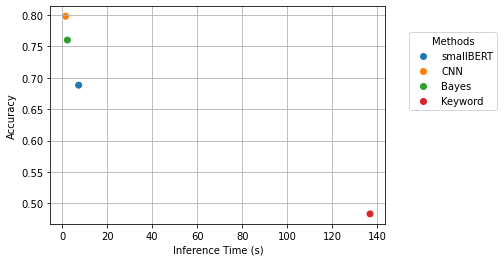

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

inference_time = [7.3, 1.54, 2.3, 136.7] # COMPLETO
training_time = [650, 440 ,10.9, 0]      # COMPLETO
f1_micro_list = [0.688, 0.79819, 0.7602, 0.4832]   # INCOMPLETO
f1_macro_list = [0.6865, 0.7978, 0.7590, 0.4891]   # INCOMPLETO

Accuracy = [0.6883, 0.7981, 0.7602, 0.4832]

label = ("smallBERT","CNN","Bayes","Keyword")

classes = ['A', 'B', 'C']
#values = [0, 1, 2, 4]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
#colors = ListedColormap(['r','b','g'])
scatter = plt.scatter(inference_time, Accuracy, c=colors)

plt.xlabel("Inference Time (s)")
plt.ylabel("Accuracy")
plt.grid(True)

handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for color in colors]

plt.legend(handles=handlelist, labels=label, title="Methods", loc = "lower right", bbox_to_anchor = (1.35,0.5))

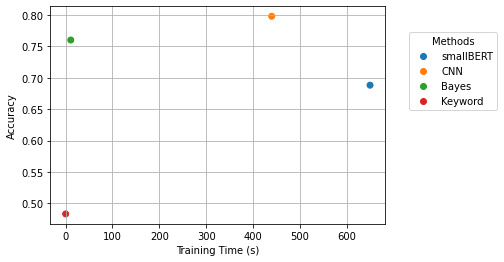

In [ ]:
inference_time = [7.3, 1.54, 2.3, 136.7] # COMPLETO
training_time = [650, 440 ,10.9, 0]      # COMPLETO
f1_micro_list = [0.688, 0.79819, 0.7602, 0.4832]   # INCOMPLETO
f1_macro_list = [0.6865, 0.7978, 0.7590, 0.4891]   # INCOMPLETO
Accuracy = [0.6883, 0.7981, 0.7602, 0.4832]

label = ("smallBERT","CNN","Bayes","Keyword")

classes = ['A', 'B', 'C']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
scatter = plt.scatter(training_time, Accuracy, c=colors)

plt.xlabel("Training Time (s)")
plt.ylabel("Accuracy")
plt.grid(True)

handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for color in colors]

plt.legend(handles=handlelist, labels=label, title="Methods", loc = "lower right", bbox_to_anchor = (1.35,0.5))

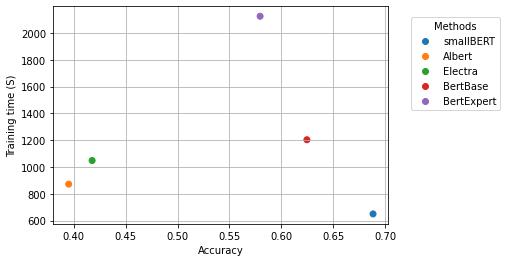

In [ ]:
inference_time = [7.3, 18.5, 7.7, 17.9, 17.8] # COMPLETO
training_time = [650, 872 ,1048, 1203, 2124]      # COMPLETO
Accuracy = [0.6883, 0.3951, 0.4177, 0.6246, 0.5795]   # INCOMPLETO


label = ("smallBERT","Albert","Electra","BertBase", "BertExpert")

classes = ['A', 'B', 'C']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
scatter = plt.scatter(Accuracy, training_time, c=colors)

plt.xlabel("Accuracy")
plt.ylabel("Training time (S)")
plt.grid(True)

handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for color in colors]

plt.legend(handles=handlelist, labels=label, title="Methods", loc = "lower right", bbox_to_anchor = (1.35,0.5))

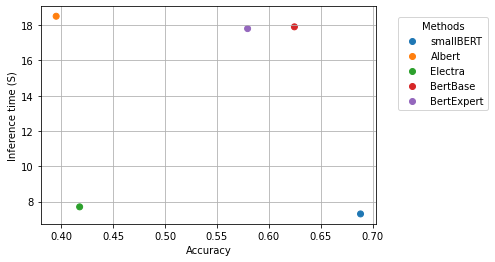

In [ ]:
inference_time = [7.3, 18.5, 7.7, 17.9, 17.8] # COMPLETO
training_time = [650, 872 ,1048, 1203, 2124]      # COMPLETO
Accuracy = [0.6883, 0.3951, 0.4177, 0.6246, 0.5795]   # INCOMPLETO


label = ("smallBERT","Albert","Electra","BertBase", "BertExpert")

classes = ['A', 'B', 'C']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
scatter = plt.scatter(Accuracy, inference_time, c=colors)

plt.xlabel("Accuracy")
plt.ylabel("Inference time (S)")
plt.grid(True)

handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for color in colors]

plt.legend(handles=handlelist, labels=label, title="Methods", loc = "lower right", bbox_to_anchor = (1.35,0.5))